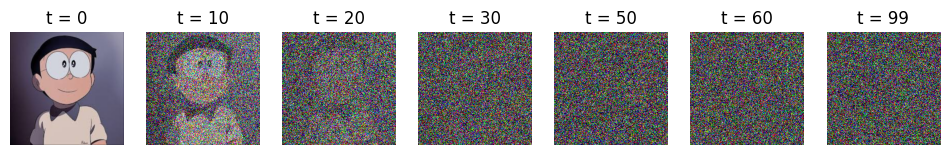

In [18]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#Load an image and convert to tensor
image_path = "nobita.jpeg" # path to any img
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
x0 = transform(image) # convert image to tensor (C, H, W)

# Define noise schedule
T = 100 # nor fo diffusion steps
alphas = torch.linspace(1, 0, T) # Decreasing alpha values
alphas_cumprod = torch.cumprod(alphas, dim=0) # cumulative product for gradual noise

# Function to add noise
def add_noise(x0, t):
  noise = torch.randn_like(x0) # generate random Gaussian noise of the same shape as x0
  xt = torch.sqrt(alphas_cumprod[t]) * x0 + torch.sqrt(1 - alphas_cumprod[t]) * noise # Gaussian Formula used
  return xt, noise

# Display images at different noise levels
fig, axes = plt.subplots(1, 7, figsize=(12, 3))
for i, t in enumerate([0, 10, 20, 30, 50, 60, 99]): # Different time steps
    xt, _ = add_noise(x0, t)
    axes[i].imshow(xt.permute(1, 2, 0).numpy())
    axes[i].set_title(f"t = {t}")
    axes[i].axis("off")

plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim


# simple U-net Model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride =1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride =2, padding=1), # Downsample
            nn.ReLU(),
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride =1, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride =2, padding=1), # Upsample
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride =1, padding=1),
            nn.Tanh(), # output in range [-1, 1]
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

# define loss function and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_step(x0, num_epochs=10):
  for epoch in range(num_epochs):
    t = torch.randint(0, T, (1,)).item() # Random timestep
    xt, noise = add_noise(x0.to(device), t) # Add noise
    optimizer.zero_grad()
    predicted_noise = model(xt.unsqueeze(0)) # Predict noise
    loss = criterion(predicted_noise, noise.to(device)) # MSE loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


# Train the model
train_step(x0)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.9963066577911377
Epoch 2/10, Loss: 0.9904055595397949
Epoch 3/10, Loss: 0.9770674109458923
Epoch 4/10, Loss: 0.9594171643257141
Epoch 5/10, Loss: 0.9246292114257812
Epoch 6/10, Loss: 0.8943696022033691
Epoch 7/10, Loss: 0.8890469670295715
Epoch 8/10, Loss: 0.8765377998352051
Epoch 9/10, Loss: 0.8334386348724365
Epoch 10/10, Loss: 0.8152584433555603


In [20]:
def reverse_diffusion(model, T= 1000):
  with torch.no_grad():
    x_t = torch.randn((1, 3, 256, 256), device=device) # start with pure noise

    for t in reversed(range(T)):
      noise_pred = model(x_t) # predict noise at current timestep
      alpha_t = alphas_cumprod[t]

      # correct denoising formula
      x_t = (x_t - (1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)

      # Ensure values are in range [-1, 1]
      x_t = torch.clamp(x_t, -1, 1)

      if t % 100 == 0: # show every 100 steps
        plt.imshow(((x_t.squeeze().permute(1, 2, 0) + 1 ) / 2 ).cpu().numpy()) # scale to [0,1]
        plt.title(f"t = {t}")
        plt.axis("off")
        plt.show()

    return x_t

    # Generate an image
    generated_image = reverse_diffusion(model)

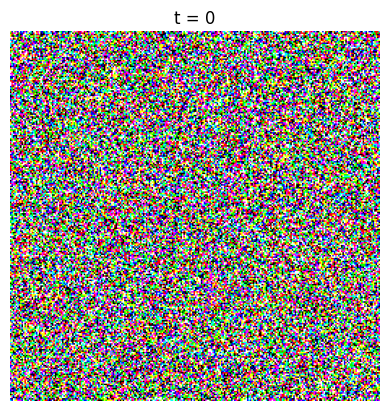

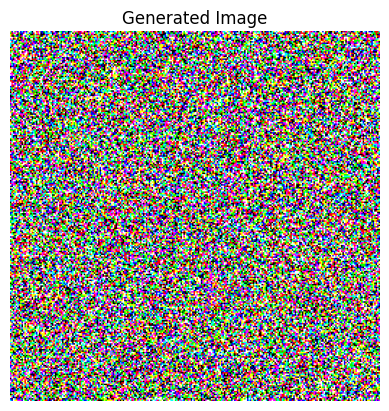

In [21]:
# Generate an image
generated_image = reverse_diffusion(model, T=T) # Use the defined T

# Display the final generated image
plt.imshow(((generated_image.squeeze().permute(1, 2, 0) + 1 ) / 2 ).cpu().numpy()) # scale to [0,1]
plt.title("Generated Image")
plt.axis("off")
plt.show()